# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    if large_ip_layer is not None:
        layer = layers.concatenate([layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    layer = separable_conv2d_batchnorm(layer, filters)
    output_layer = separable_conv2d_batchnorm(layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    # inputs 160x160x3 -> 160x160x10
    encoder_0 = encoder_block(inputs, 10, 1)
    # encoder_0 -> encoder_1 80x80x32
    encoder_1 = encoder_block(encoder_0, 32, 2)
    # encoder_1 -> encoder_2 40x40x100
    encoder_2 = encoder_block(encoder_1, 100, 2)
    # encoder_2 -> encoder_3 20x20x200
    encoder_3 = encoder_block(encoder_2, 200, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    # encoder_3 -> encoded 20x20x512
    encoded = conv2d_batchnorm(encoder_3, filters=512, kernel_size=1, strides=1)
    
    
    # upsamp(encoded)+ encoder_2 40x40x(512+100) -> decoder_1 40x40x200
    decoder_1 = decoder_block(encoded, encoder_2, 200)
    # upsamp(decoder_1)+ encoder_1 80x80x(200+32) -> decoder_2 80x80x100
    decoder_2 = decoder_block(decoder_1, encoder_1, 100)
    # upsamp(decoder_2)+ encoder_0 180x180x(100+10) -> decoder_3 180x180x32
    decoder_3 = decoder_block(decoder_2, encoder_0, 32)
    
    x = decoder_3
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    # x 128x128x32 -> 128x128x(num_classes)
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [11]:
learning_rate = 0.001 # base learning rate ( 10x boosted for 3 episodes, decaying after 10 epochs )
batch_size = 64
num_epochs = 100
steps_per_epoch = 200
validation_steps = 50
workers = 16

In [12]:
def lr_schedule(epoch):
    if epoch < 3:
        lr = learning_rate * 10    # boost period 
    else:
        lr = learning_rate * np.power(0.975, epoch-10)
        lr = np.clip(lr, 1e-4, 1e-3)
    print('learning rate:{}'.format(lr))
    return lr

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
weight_file_name = 'model_weights'

model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

learning rate:0.01
Epoch 1/100
199/200 [============================>.] - ETA: 1s - loss: 0.1028

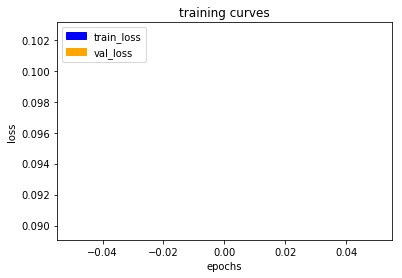

200/200 [==============================] - 384s - loss: 0.1024 - val_loss: 0.0897
learning rate:0.01
Epoch 2/100
199/200 [============================>.] - ETA: 1s - loss: 0.0252

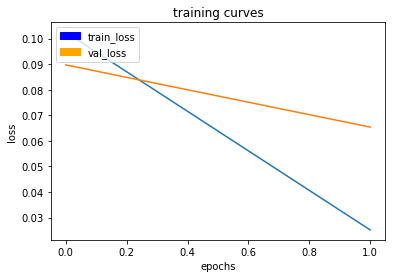

200/200 [==============================] - 370s - loss: 0.0252 - val_loss: 0.0654
learning rate:0.01
Epoch 3/100
199/200 [============================>.] - ETA: 1s - loss: 0.0211

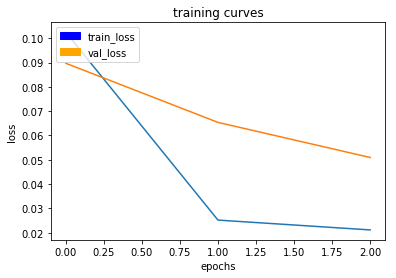

200/200 [==============================] - 370s - loss: 0.0211 - val_loss: 0.0510
learning rate:0.001
Epoch 4/100
199/200 [============================>.] - ETA: 1s - loss: 0.0182

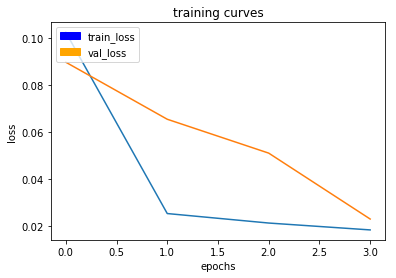

200/200 [==============================] - 370s - loss: 0.0182 - val_loss: 0.0228
learning rate:0.001
Epoch 5/100
199/200 [============================>.] - ETA: 1s - loss: 0.0167

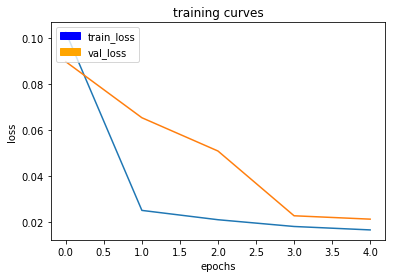

200/200 [==============================] - 370s - loss: 0.0167 - val_loss: 0.0214
learning rate:0.001
Epoch 6/100
199/200 [============================>.] - ETA: 1s - loss: 0.0154

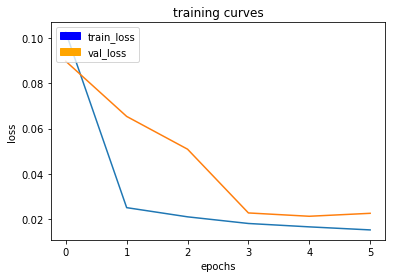

200/200 [==============================] - 370s - loss: 0.0154 - val_loss: 0.0227
learning rate:0.001
Epoch 7/100
199/200 [============================>.] - ETA: 1s - loss: 0.0157

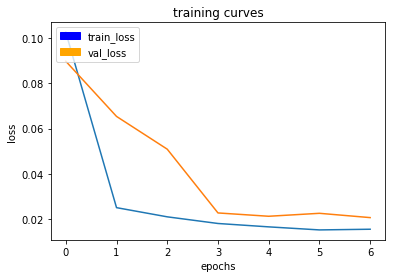

200/200 [==============================] - 370s - loss: 0.0157 - val_loss: 0.0208
learning rate:0.001
Epoch 8/100
199/200 [============================>.] - ETA: 1s - loss: 0.0151

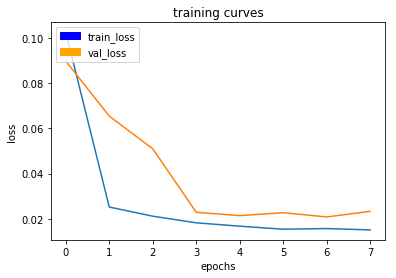

200/200 [==============================] - 370s - loss: 0.0151 - val_loss: 0.0233
learning rate:0.001
Epoch 9/100
199/200 [============================>.] - ETA: 1s - loss: 0.0141

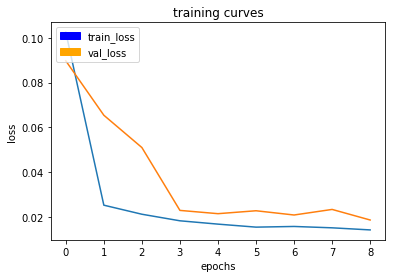

200/200 [==============================] - 370s - loss: 0.0141 - val_loss: 0.0186
learning rate:0.001
Epoch 10/100
199/200 [============================>.] - ETA: 1s - loss: 0.0146

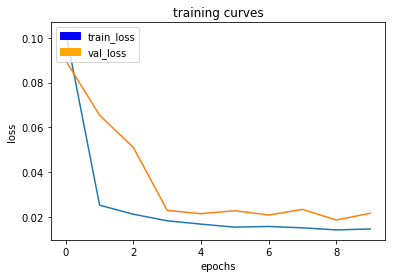

200/200 [==============================] - 369s - loss: 0.0145 - val_loss: 0.0216
learning rate:0.001
Epoch 11/100
199/200 [============================>.] - ETA: 1s - loss: 0.0139

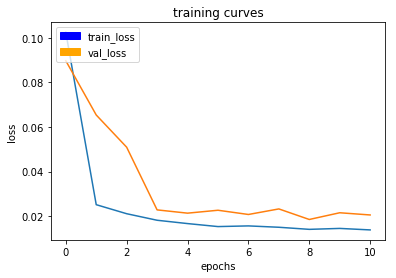

200/200 [==============================] - 370s - loss: 0.0139 - val_loss: 0.0206
learning rate:0.000975
Epoch 12/100
199/200 [============================>.] - ETA: 1s - loss: 0.0134

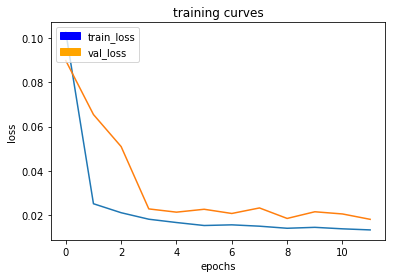

200/200 [==============================] - 370s - loss: 0.0134 - val_loss: 0.0182
learning rate:0.000950625
Epoch 13/100
199/200 [============================>.] - ETA: 1s - loss: 0.0130

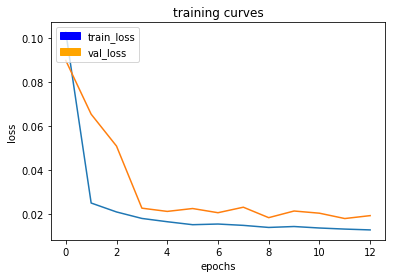

200/200 [==============================] - 369s - loss: 0.0130 - val_loss: 0.0195
learning rate:0.000926859375
Epoch 14/100
199/200 [============================>.] - ETA: 1s - loss: 0.0124

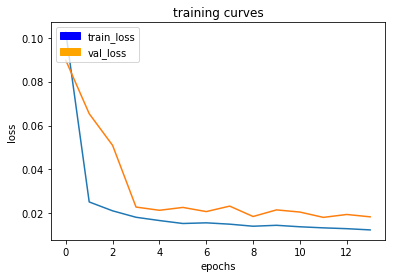

200/200 [==============================] - 370s - loss: 0.0124 - val_loss: 0.0184
learning rate:0.0009036878906249999
Epoch 15/100
199/200 [============================>.] - ETA: 1s - loss: 0.0125

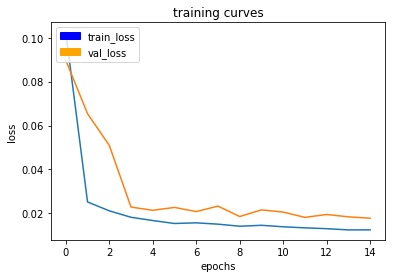

200/200 [==============================] - 370s - loss: 0.0125 - val_loss: 0.0178
learning rate:0.0008810956933593749
Epoch 16/100
199/200 [============================>.] - ETA: 1s - loss: 0.0123

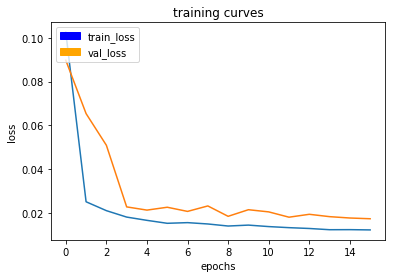

200/200 [==============================] - 370s - loss: 0.0124 - val_loss: 0.0174
learning rate:0.0008590683010253905
Epoch 17/100
199/200 [============================>.] - ETA: 1s - loss: 0.0117

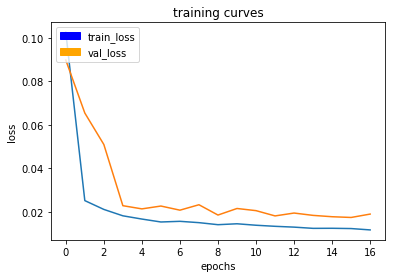

200/200 [==============================] - 372s - loss: 0.0117 - val_loss: 0.0190
learning rate:0.0008375915934997558
Epoch 18/100
199/200 [============================>.] - ETA: 1s - loss: 0.0115

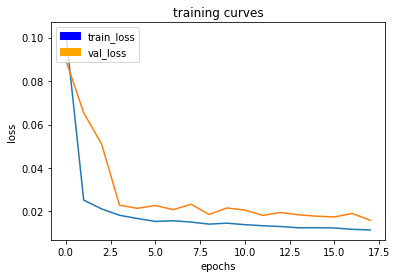

200/200 [==============================] - 370s - loss: 0.0115 - val_loss: 0.0159
learning rate:0.0008166518036622619
Epoch 19/100
199/200 [============================>.] - ETA: 1s - loss: 0.0115

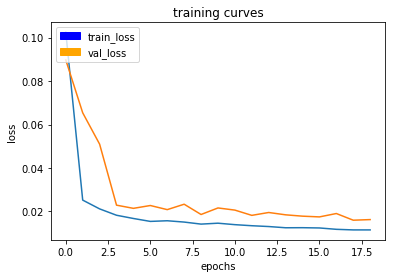

200/200 [==============================] - 370s - loss: 0.0115 - val_loss: 0.0162
learning rate:0.0007962355085707053
Epoch 20/100
199/200 [============================>.] - ETA: 1s - loss: 0.0113

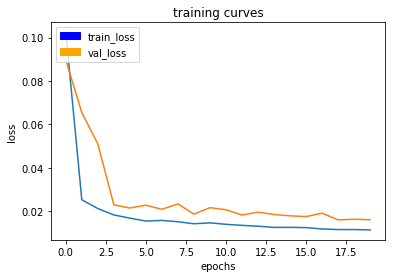

200/200 [==============================] - 369s - loss: 0.0113 - val_loss: 0.0160
learning rate:0.0007763296208564376
Epoch 21/100
199/200 [============================>.] - ETA: 1s - loss: 0.0109

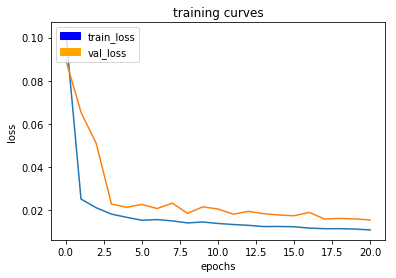

200/200 [==============================] - 370s - loss: 0.0109 - val_loss: 0.0155
learning rate:0.0007569213803350266
Epoch 22/100
199/200 [============================>.] - ETA: 1s - loss: 0.0108

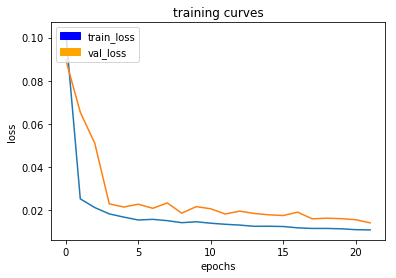

200/200 [==============================] - 369s - loss: 0.0108 - val_loss: 0.0140
learning rate:0.000737998345826651
Epoch 23/100
199/200 [============================>.] - ETA: 1s - loss: 0.0103

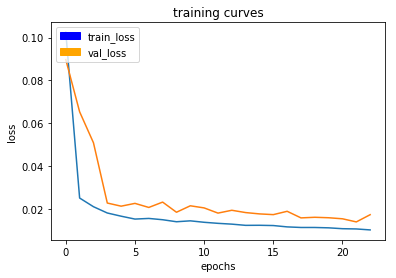

200/200 [==============================] - 370s - loss: 0.0103 - val_loss: 0.0174
learning rate:0.0007195483871809847
Epoch 24/100
199/200 [============================>.] - ETA: 1s - loss: 0.0108

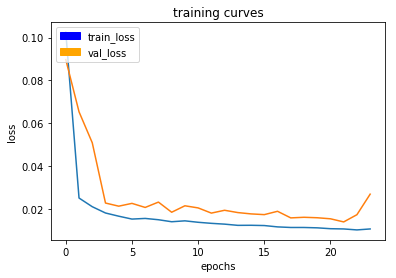

200/200 [==============================] - 370s - loss: 0.0108 - val_loss: 0.0270
learning rate:0.0007015596775014601
Epoch 25/100
199/200 [============================>.] - ETA: 1s - loss: 0.0100

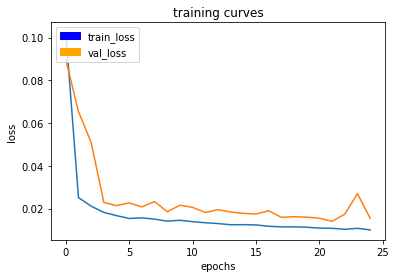

200/200 [==============================] - 370s - loss: 0.0100 - val_loss: 0.0155
learning rate:0.0006840206855639235
Epoch 26/100
199/200 [============================>.] - ETA: 1s - loss: 0.0099

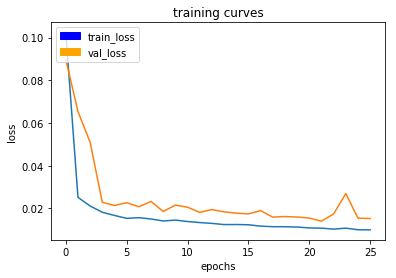

200/200 [==============================] - 369s - loss: 0.0099 - val_loss: 0.0153
learning rate:0.0006669201684248254
Epoch 27/100
199/200 [============================>.] - ETA: 1s - loss: 0.0095

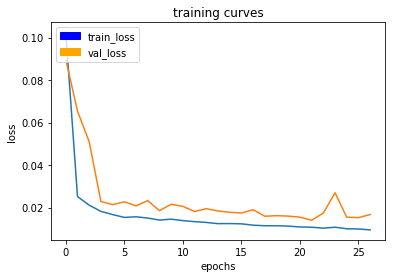

200/200 [==============================] - 369s - loss: 0.0095 - val_loss: 0.0167
learning rate:0.0006502471642142048
Epoch 28/100
199/200 [============================>.] - ETA: 1s - loss: 0.0096

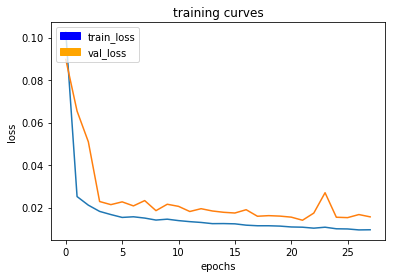

200/200 [==============================] - 370s - loss: 0.0096 - val_loss: 0.0156
learning rate:0.0006339909851088497
Epoch 29/100
199/200 [============================>.] - ETA: 1s - loss: 0.0095

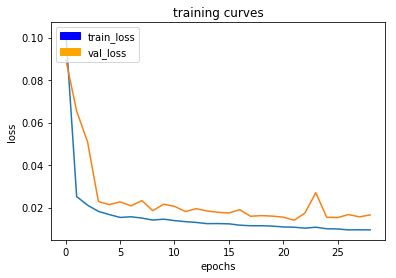

200/200 [==============================] - 370s - loss: 0.0095 - val_loss: 0.0165
learning rate:0.0006181412104811284
Epoch 30/100
199/200 [============================>.] - ETA: 1s - loss: 0.0090

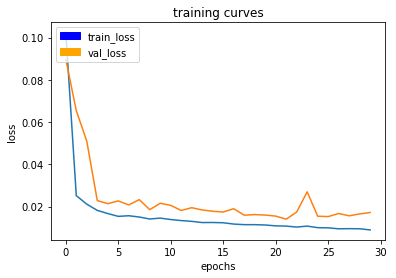

200/200 [==============================] - 371s - loss: 0.0090 - val_loss: 0.0172
learning rate:0.0006026876802191001
Epoch 31/100
199/200 [============================>.] - ETA: 1s - loss: 0.0094

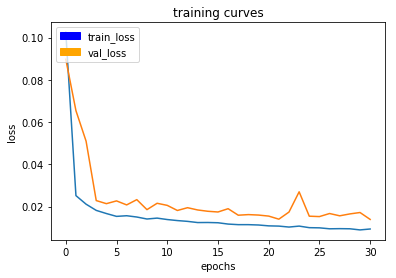

200/200 [==============================] - 370s - loss: 0.0094 - val_loss: 0.0139
learning rate:0.0005876204882136227
Epoch 32/100
199/200 [============================>.] - ETA: 1s - loss: 0.0090

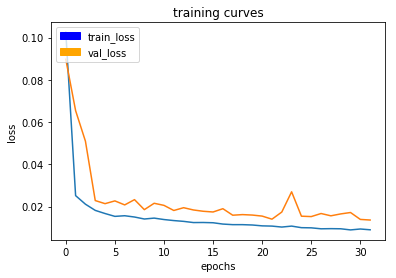

200/200 [==============================] - 369s - loss: 0.0090 - val_loss: 0.0136
learning rate:0.0005729299760082821
Epoch 33/100
199/200 [============================>.] - ETA: 1s - loss: 0.0090

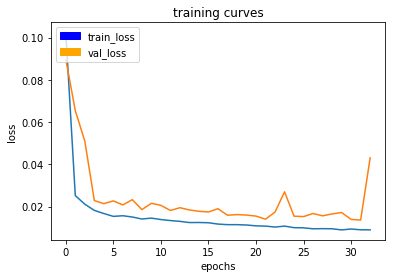

200/200 [==============================] - 369s - loss: 0.0090 - val_loss: 0.0431
learning rate:0.0005586067266080749
Epoch 34/100
199/200 [============================>.] - ETA: 1s - loss: 0.0094

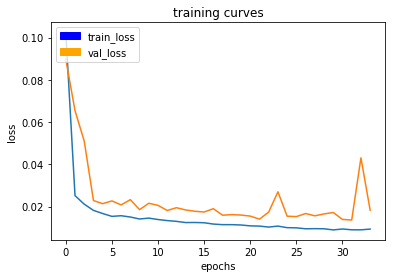

200/200 [==============================] - 370s - loss: 0.0094 - val_loss: 0.0183
learning rate:0.0005446415584428731
Epoch 35/100
199/200 [============================>.] - ETA: 1s - loss: 0.0087

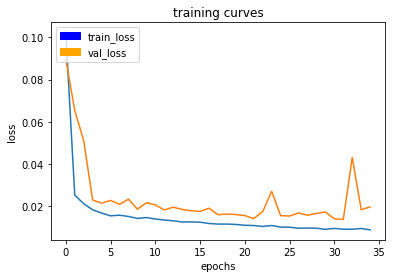

200/200 [==============================] - 370s - loss: 0.0087 - val_loss: 0.0196
learning rate:0.0005310255194818013
Epoch 36/100
199/200 [============================>.] - ETA: 1s - loss: 0.0085

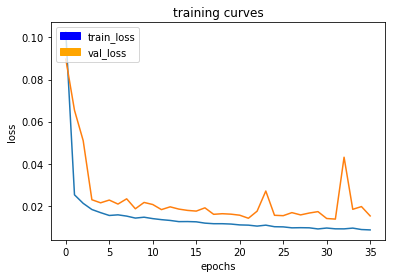

200/200 [==============================] - 369s - loss: 0.0085 - val_loss: 0.0152
learning rate:0.0005177498814947562
Epoch 37/100
199/200 [============================>.] - ETA: 1s - loss: 0.0093

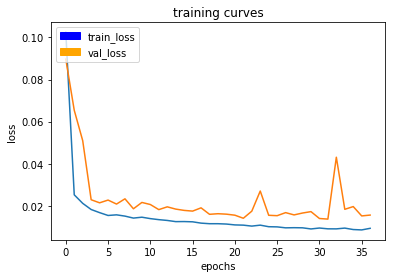

200/200 [==============================] - 370s - loss: 0.0093 - val_loss: 0.0156
learning rate:0.0005048061344573873
Epoch 38/100
199/200 [============================>.] - ETA: 1s - loss: 0.0088

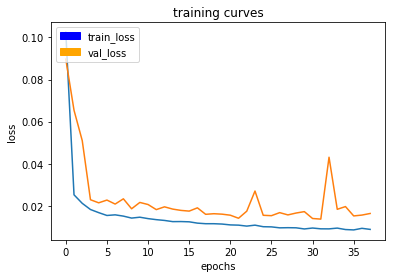

200/200 [==============================] - 370s - loss: 0.0087 - val_loss: 0.0163
learning rate:0.0004921859810959527
Epoch 39/100
199/200 [============================>.] - ETA: 1s - loss: 0.0083

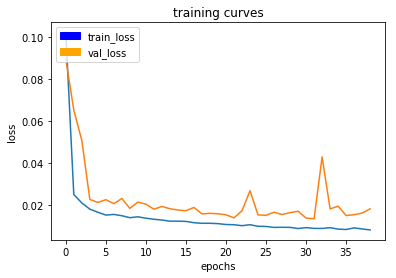

200/200 [==============================] - 369s - loss: 0.0083 - val_loss: 0.0183
learning rate:0.0004798813315685538
Epoch 40/100
199/200 [============================>.] - ETA: 1s - loss: 0.0083

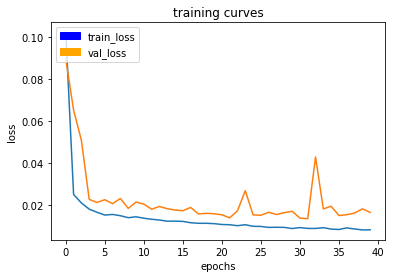

200/200 [==============================] - 370s - loss: 0.0083 - val_loss: 0.0166
learning rate:0.00046788429827933993
Epoch 41/100
199/200 [============================>.] - ETA: 1s - loss: 0.0083

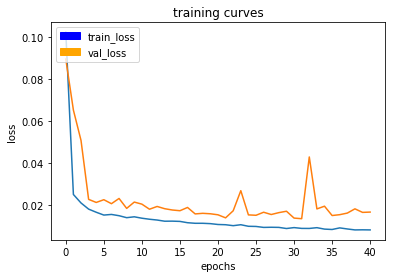

200/200 [==============================] - 370s - loss: 0.0083 - val_loss: 0.0168
learning rate:0.00045618719082235644
Epoch 42/100
199/200 [============================>.] - ETA: 1s - loss: 0.0081

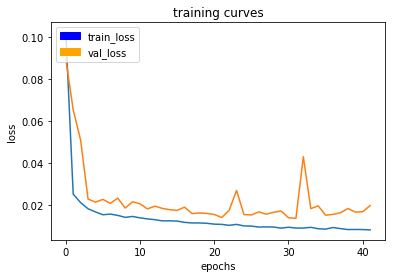

200/200 [==============================] - 370s - loss: 0.0081 - val_loss: 0.0198
learning rate:0.0004447825110517975
Epoch 43/100
199/200 [============================>.] - ETA: 1s - loss: 0.0079

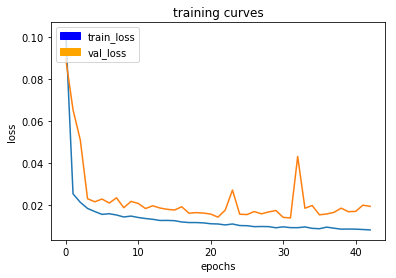

200/200 [==============================] - 369s - loss: 0.0079 - val_loss: 0.0192
learning rate:0.0004336629482755026
Epoch 44/100
199/200 [============================>.] - ETA: 1s - loss: 0.0079

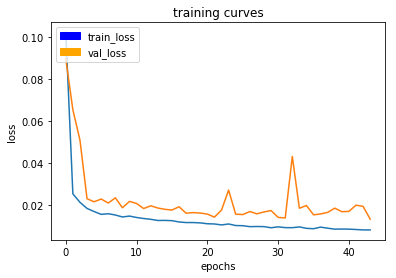

200/200 [==============================] - 370s - loss: 0.0079 - val_loss: 0.0131
learning rate:0.000422821374568615
Epoch 45/100
199/200 [============================>.] - ETA: 1s - loss: 0.0082

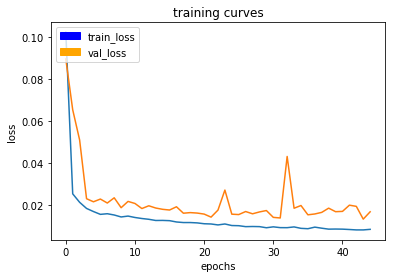

200/200 [==============================] - 370s - loss: 0.0082 - val_loss: 0.0166
learning rate:0.0004122508402043996
Epoch 46/100
199/200 [============================>.] - ETA: 1s - loss: 0.0078

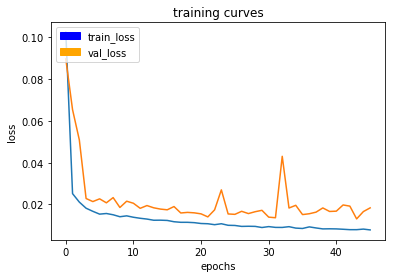

200/200 [==============================] - 370s - loss: 0.0078 - val_loss: 0.0184
learning rate:0.00040194456919928964
Epoch 47/100
199/200 [============================>.] - ETA: 1s - loss: 0.0077

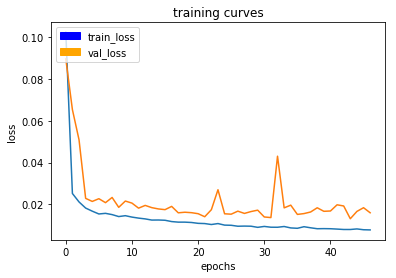

200/200 [==============================] - 371s - loss: 0.0077 - val_loss: 0.0159
learning rate:0.00039189595496930737
Epoch 48/100
199/200 [============================>.] - ETA: 1s - loss: 0.0081

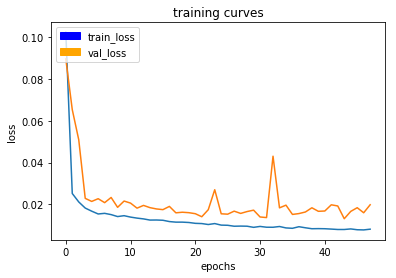

200/200 [==============================] - 370s - loss: 0.0081 - val_loss: 0.0198
learning rate:0.00038209855609507465
Epoch 49/100
199/200 [============================>.] - ETA: 1s - loss: 0.0078

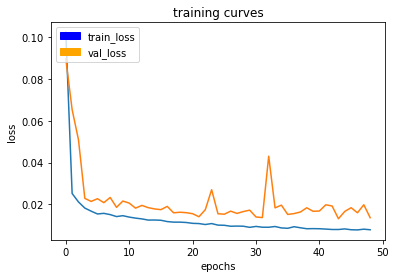

200/200 [==============================] - 370s - loss: 0.0078 - val_loss: 0.0136
learning rate:0.0003725460921926978
Epoch 50/100
199/200 [============================>.] - ETA: 1s - loss: 0.0082

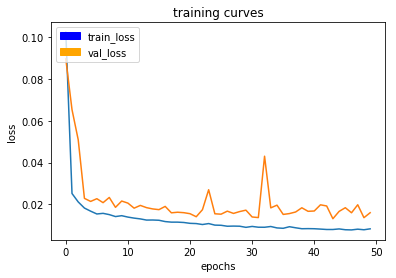

200/200 [==============================] - 370s - loss: 0.0082 - val_loss: 0.0160
learning rate:0.00036323243988788036
Epoch 51/100
199/200 [============================>.] - ETA: 1s - loss: 0.0076

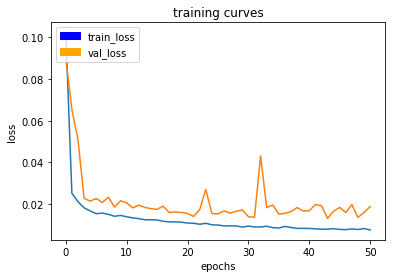

200/200 [==============================] - 370s - loss: 0.0076 - val_loss: 0.0188
learning rate:0.0003541516288906833
Epoch 52/100
199/200 [============================>.] - ETA: 1s - loss: 0.0076

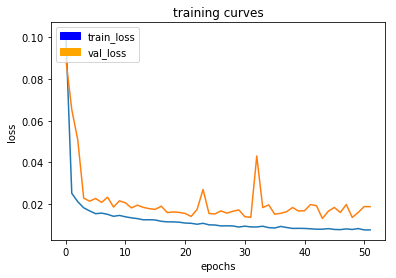

200/200 [==============================] - 370s - loss: 0.0076 - val_loss: 0.0188
learning rate:0.00034529783816841624
Epoch 53/100
199/200 [============================>.] - ETA: 1s - loss: 0.0074

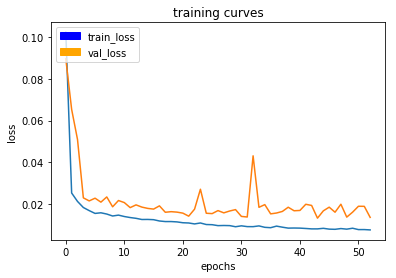

200/200 [==============================] - 369s - loss: 0.0074 - val_loss: 0.0135
learning rate:0.0003366653922142058
Epoch 54/100
199/200 [============================>.] - ETA: 1s - loss: 0.0082

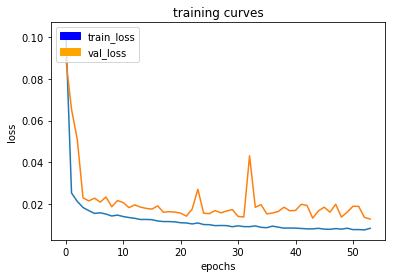

200/200 [==============================] - 370s - loss: 0.0082 - val_loss: 0.0127
learning rate:0.0003282487574088507
Epoch 55/100
199/200 [============================>.] - ETA: 1s - loss: 0.0075

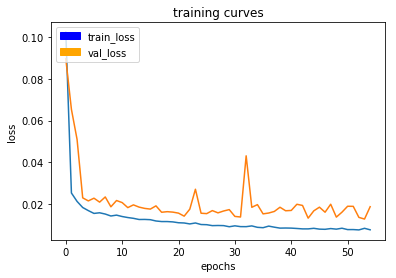

200/200 [==============================] - 370s - loss: 0.0075 - val_loss: 0.0186
learning rate:0.0003200425384736294
Epoch 56/100
199/200 [============================>.] - ETA: 1s - loss: 0.0074

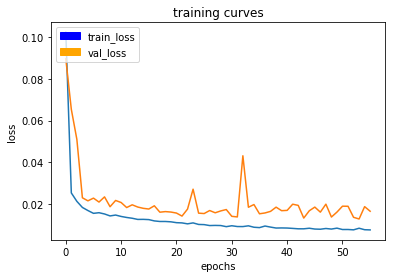

200/200 [==============================] - 370s - loss: 0.0074 - val_loss: 0.0164
learning rate:0.00031204147501178863
Epoch 57/100
199/200 [============================>.] - ETA: 1s - loss: 0.0073

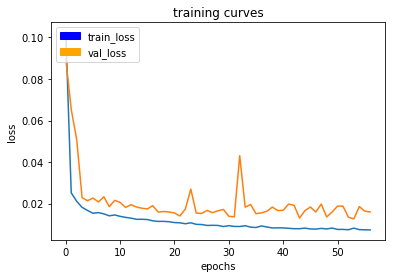

200/200 [==============================] - 370s - loss: 0.0073 - val_loss: 0.0160
learning rate:0.00030424043813649394
Epoch 58/100
199/200 [============================>.] - ETA: 1s - loss: 0.0074

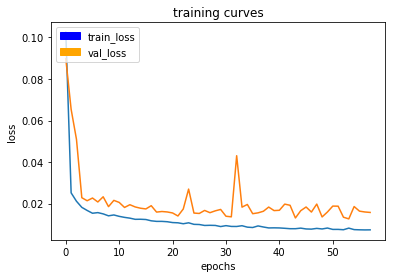

200/200 [==============================] - 369s - loss: 0.0074 - val_loss: 0.0158
learning rate:0.0002966344271830816
Epoch 59/100
199/200 [============================>.] - ETA: 1s - loss: 0.0074

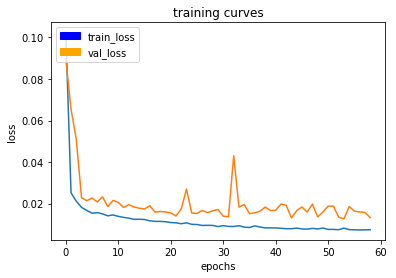

200/200 [==============================] - 370s - loss: 0.0074 - val_loss: 0.0133
learning rate:0.00028921856650350453
Epoch 60/100
199/200 [============================>.] - ETA: 1s - loss: 0.0073

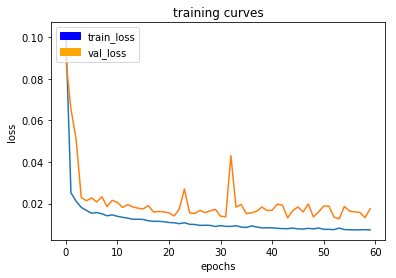

200/200 [==============================] - 372s - loss: 0.0073 - val_loss: 0.0175
learning rate:0.00028198810234091693
Epoch 61/100
199/200 [============================>.] - ETA: 1s - loss: 0.0072

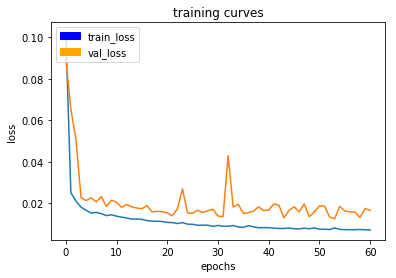

200/200 [==============================] - 370s - loss: 0.0072 - val_loss: 0.0166
learning rate:0.000274938399782394
Epoch 62/100
199/200 [============================>.] - ETA: 1s - loss: 0.0072

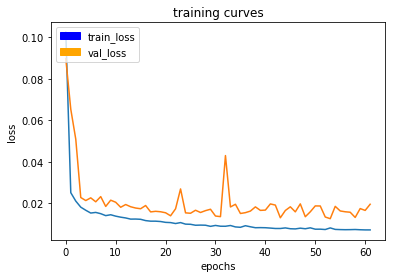

200/200 [==============================] - 370s - loss: 0.0072 - val_loss: 0.0196
learning rate:0.00026806493978783413
Epoch 63/100
199/200 [============================>.] - ETA: 1s - loss: 0.0072

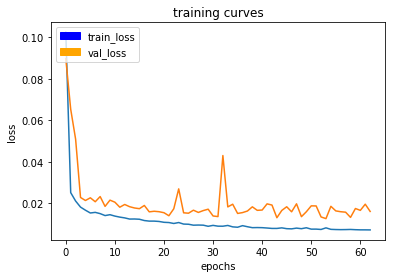

200/200 [==============================] - 370s - loss: 0.0072 - val_loss: 0.0161
learning rate:0.00026136331629313824
Epoch 64/100
199/200 [============================>.] - ETA: 1s - loss: 0.0071

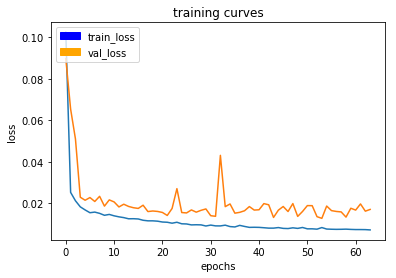

200/200 [==============================] - 369s - loss: 0.0071 - val_loss: 0.0170
learning rate:0.00025482923338580985
Epoch 65/100
199/200 [============================>.] - ETA: 1s - loss: 0.0071

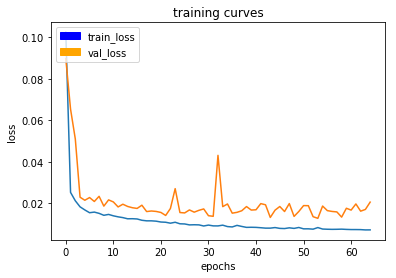

200/200 [==============================] - 370s - loss: 0.0071 - val_loss: 0.0205
learning rate:0.00024845850255116454
Epoch 66/100
199/200 [============================>.] - ETA: 1s - loss: 0.0070

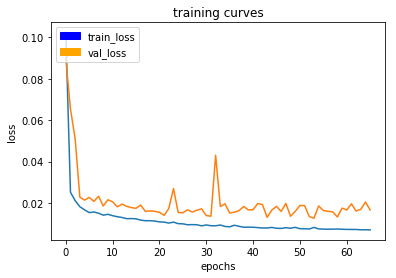

200/200 [==============================] - 370s - loss: 0.0070 - val_loss: 0.0166
learning rate:0.00024224703998738543
Epoch 67/100
199/200 [============================>.] - ETA: 1s - loss: 0.0070

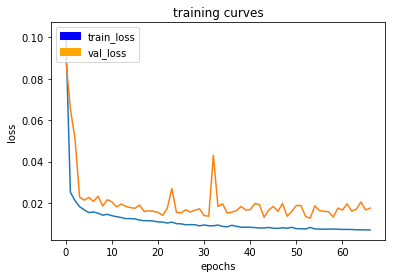

200/200 [==============================] - 370s - loss: 0.0070 - val_loss: 0.0175
learning rate:0.0002361908639877008
Epoch 68/100
199/200 [============================>.] - ETA: 1s - loss: 0.0070

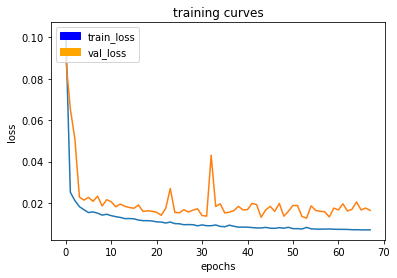

200/200 [==============================] - 370s - loss: 0.0070 - val_loss: 0.0164
learning rate:0.00023028609238800828
Epoch 69/100
199/200 [============================>.] - ETA: 1s - loss: 0.0069

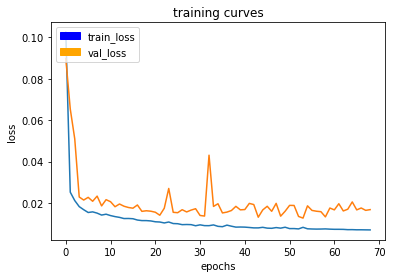

200/200 [==============================] - 370s - loss: 0.0069 - val_loss: 0.0168
learning rate:0.00022452894007830805
Epoch 70/100
199/200 [============================>.] - ETA: 1s - loss: 0.0070

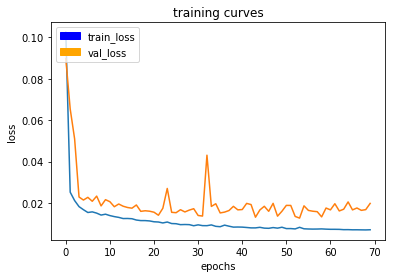

200/200 [==============================] - 371s - loss: 0.0070 - val_loss: 0.0198
learning rate:0.00021891571657635034
Epoch 71/100
199/200 [============================>.] - ETA: 1s - loss: 0.0069

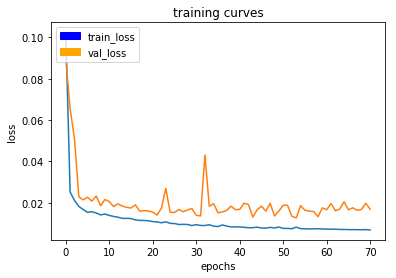

200/200 [==============================] - 370s - loss: 0.0069 - val_loss: 0.0169
learning rate:0.0002134428236619416
Epoch 72/100
199/200 [============================>.] - ETA: 1s - loss: 0.0069

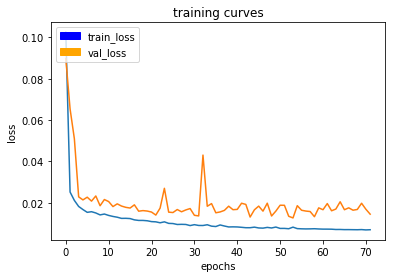

200/200 [==============================] - 370s - loss: 0.0069 - val_loss: 0.0145
learning rate:0.00020810675307039302
Epoch 73/100
199/200 [============================>.] - ETA: 1s - loss: 0.0071

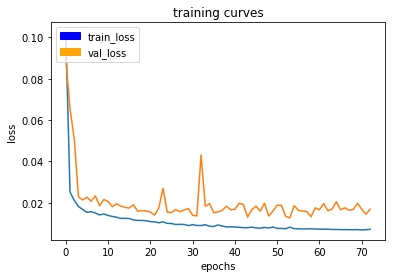

200/200 [==============================] - 371s - loss: 0.0071 - val_loss: 0.0169
learning rate:0.0002029040842436332
Epoch 74/100
199/200 [============================>.] - ETA: 1s - loss: 0.0068

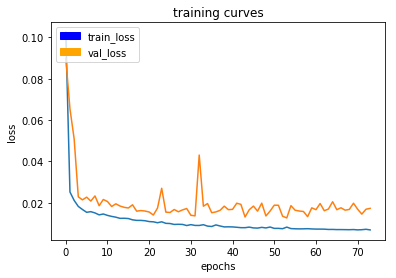

200/200 [==============================] - 369s - loss: 0.0068 - val_loss: 0.0173
learning rate:0.00019783148213754238
Epoch 75/100
199/200 [============================>.] - ETA: 1s - loss: 0.0068

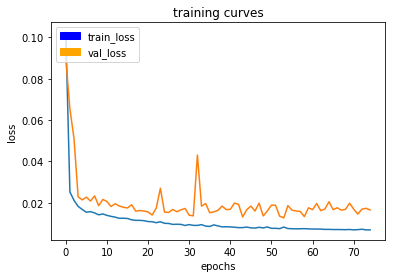

200/200 [==============================] - 369s - loss: 0.0068 - val_loss: 0.0165
learning rate:0.0001928856950841038
Epoch 76/100
199/200 [============================>.] - ETA: 1s - loss: 0.0069

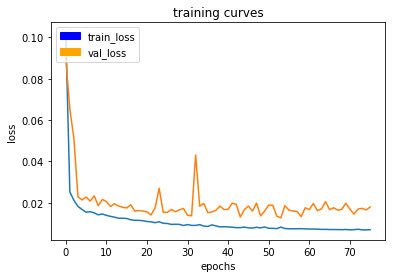

200/200 [==============================] - 370s - loss: 0.0069 - val_loss: 0.0179
learning rate:0.0001880635527070012
Epoch 77/100
199/200 [============================>.] - ETA: 1s - loss: 0.0068

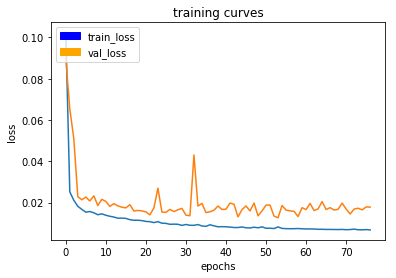

200/200 [==============================] - 370s - loss: 0.0068 - val_loss: 0.0178
learning rate:0.00018336196388932615
Epoch 78/100
199/200 [============================>.] - ETA: 1s - loss: 0.0068

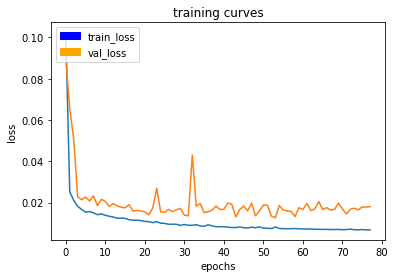

200/200 [==============================] - 370s - loss: 0.0068 - val_loss: 0.0180
learning rate:0.00017877791479209301
Epoch 79/100
199/200 [============================>.] - ETA: 1s - loss: 0.0067

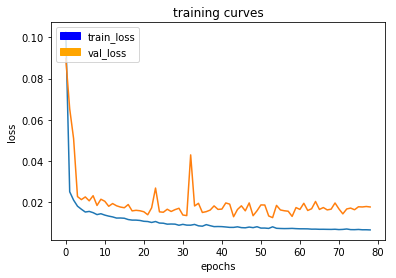

200/200 [==============================] - 370s - loss: 0.0067 - val_loss: 0.0178
learning rate:0.00017430846692229068
Epoch 80/100
199/200 [============================>.] - ETA: 1s - loss: 0.0068

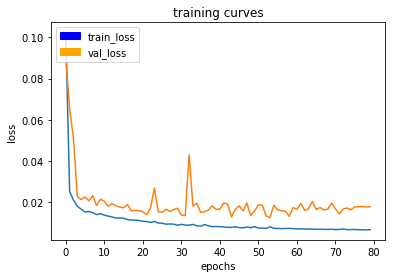

200/200 [==============================] - 370s - loss: 0.0068 - val_loss: 0.0179
learning rate:0.00016995075524923342
Epoch 81/100
199/200 [============================>.] - ETA: 1s - loss: 0.0067

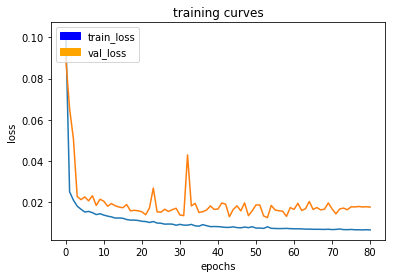

200/200 [==============================] - 370s - loss: 0.0067 - val_loss: 0.0178
learning rate:0.00016570198636800258
Epoch 82/100
199/200 [============================>.] - ETA: 1s - loss: 0.0067

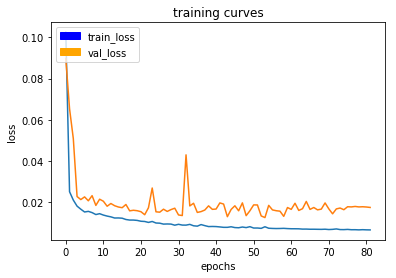

200/200 [==============================] - 370s - loss: 0.0067 - val_loss: 0.0176
learning rate:0.00016155943670880253
Epoch 83/100
199/200 [============================>.] - ETA: 1s - loss: 0.0067

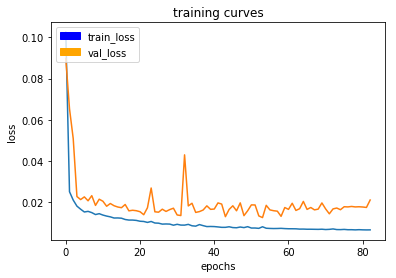

200/200 [==============================] - 370s - loss: 0.0067 - val_loss: 0.0212
learning rate:0.00015752045079108244
Epoch 84/100
199/200 [============================>.] - ETA: 1s - loss: 0.0066

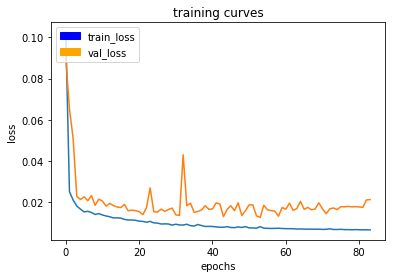

200/200 [==============================] - 370s - loss: 0.0066 - val_loss: 0.0213
learning rate:0.00015358243952130537
Epoch 85/100
199/200 [============================>.] - ETA: 1s - loss: 0.0067

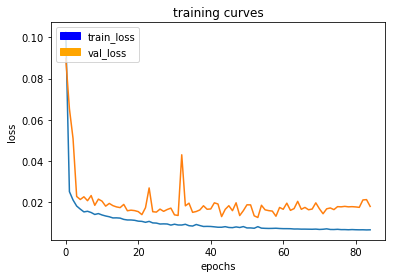

200/200 [==============================] - 370s - loss: 0.0067 - val_loss: 0.0180
learning rate:0.00014974287853327273
Epoch 86/100
199/200 [============================>.] - ETA: 1s - loss: 0.0068

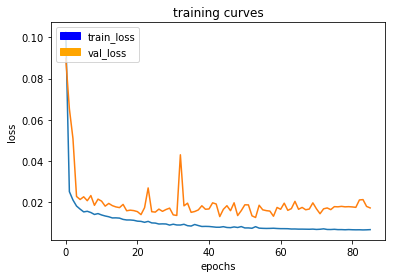

200/200 [==============================] - 371s - loss: 0.0068 - val_loss: 0.0173
learning rate:0.00014599930656994094
Epoch 87/100
199/200 [============================>.] - ETA: 1s - loss: 0.0067

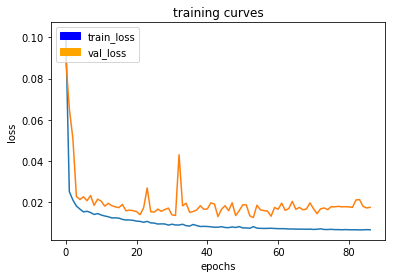

200/200 [==============================] - 370s - loss: 0.0067 - val_loss: 0.0176
learning rate:0.0001423493239056924
Epoch 88/100
199/200 [============================>.] - ETA: 1s - loss: 0.0066

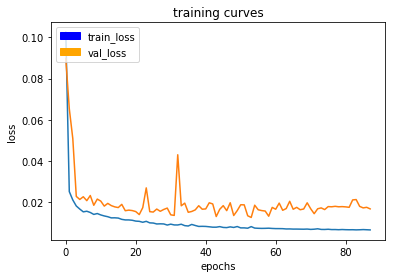

200/200 [==============================] - 370s - loss: 0.0066 - val_loss: 0.0168
learning rate:0.00013879059080805007
Epoch 89/100
199/200 [============================>.] - ETA: 1s - loss: 0.0066

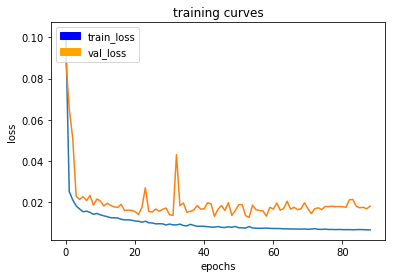

200/200 [==============================] - 370s - loss: 0.0066 - val_loss: 0.0181
learning rate:0.00013532082603784883
Epoch 90/100
 38/200 [====>.........................] - ETA: 280s - loss: 0.0067

In [ ]:
# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
lr_schedule_cb = keras.callbacks.LearningRateScheduler(lr_schedule)

model_cp_file = os.path.join('..', 'data', 'weights', 'model_checkpoint')
model_cp_cb = keras.callbacks.ModelCheckpoint(model_cp_file, monitor='val_loss', verbose=0, 
                                                   save_best_only=False, save_weights_only=False, 
                                                   mode='auto', period=1)

callbacks = [logger_cb, lr_schedule_cb, model_cp_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [16]:
# Save your trained model weights
weight_file_name = 'model_weights_aws_3'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# model = model_tools.load_network(weight_file_name)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [26]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

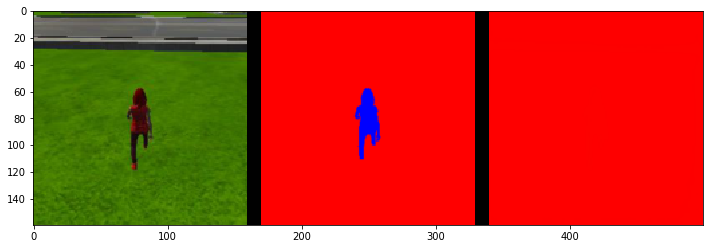

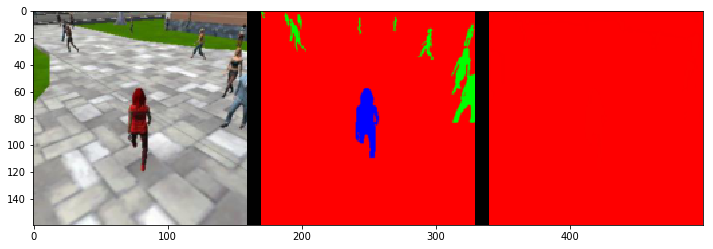

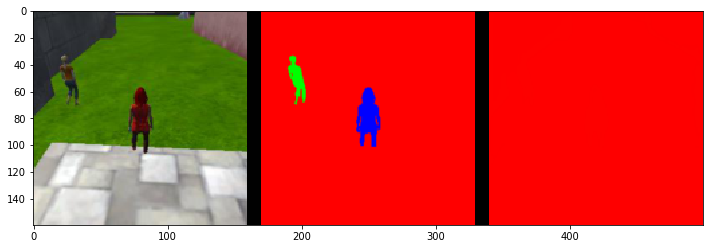

In [27]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

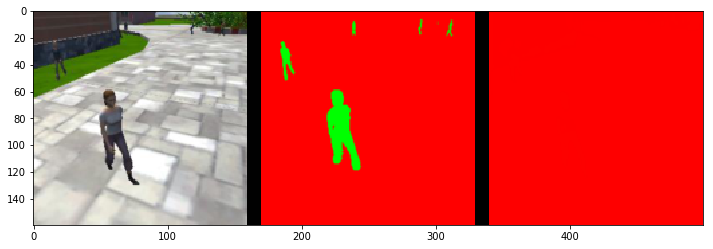

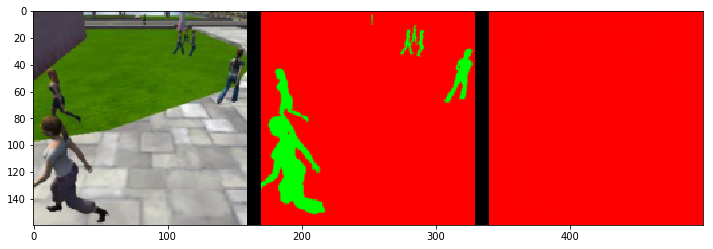

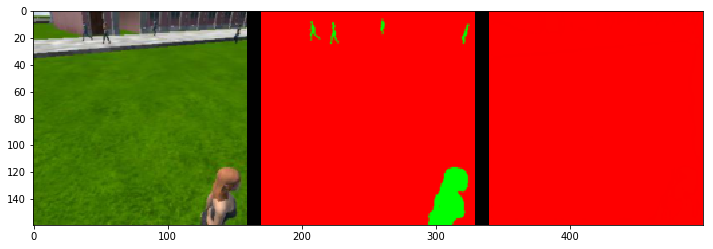

In [28]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

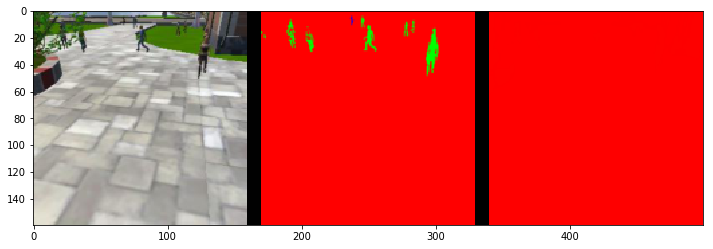

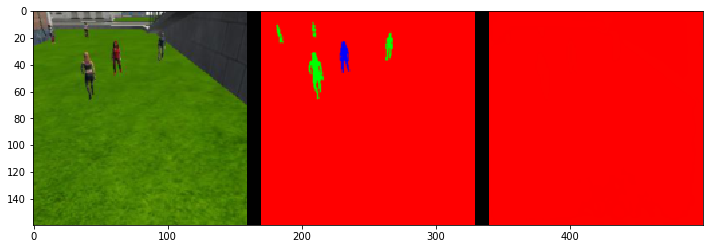

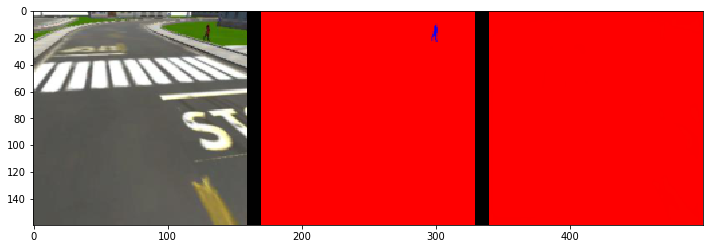

In [29]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [30]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9719131976476029
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 539


In [31]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.954649016203703
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 0


In [32]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9897817595108703
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 0, number false negatives: 301


In [33]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.0


In [34]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.0


In [35]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.0
